In [1]:
import tensorflow as tf
import librosa
import numpy as np

In [2]:
model = tf.keras.models.load_model("piano_note_recognition_cnn.h5")


In [4]:
# === CQT Configuration ===
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)

In [29]:
# audio_path = r'gen_audio\custom-sequence.mp3'
# y, _ = librosa.load(audio_path, sr=sr)

# C = librosa.cqt(
#     y, sr=sr,
#     hop_length=hop_length,
#     fmin=fmin,
#     n_bins=n_bins,
#     bins_per_octave=bins_per_octave
# )
# C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)
import os
audio_path = r"F:\Dataset_open_topic\maestro-v3.0.0_all\Processed_data\train2"
temp = []
for i in range(5):
    audio = os.path.join(audio_path, f'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav_{i}.npy')
    cqt_data = np.load(audio)
    temp.append(cqt_data)

C_dB = np.concatenate(temp, axis=1)
C_dB.shape

(267, 5005)

In [31]:
X_test = C_dB[:, :5000]
X_test.shape

(267, 5000)

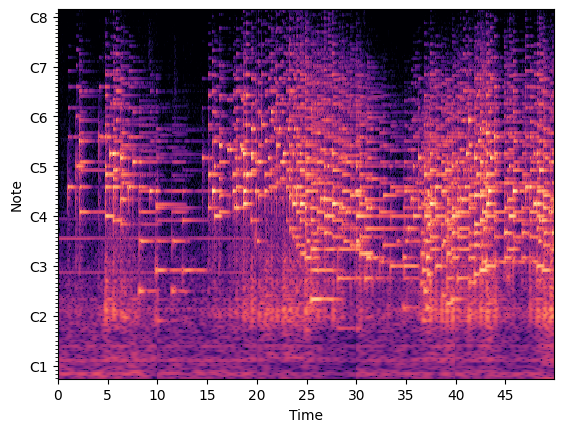

In [32]:
librosa.display.specshow(X_test, sr=sr, hop_length=hop_length,
                            x_axis='time', y_axis='cqt_note',
                            fmin=fmin, bins_per_octave=bins_per_octave,
                            cmap='magma')


In [33]:

def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2  # pad equally on both sides
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')  # pad only time axis
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]  # shape: (267, window_size)
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis]  # shape: (1000, 267, 9, 1)


X_input = create_sliding_windows(X_test, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window X_input Shape:", X_input.shape)

Sliding Window X_input Shape: (5000, 267, 9, 1)


In [39]:
predict = model.predict(X_input)

print("Output size : ", predict.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Output size :  (5000, 128)


In [40]:
import pretty_midi
import numpy as np

def model_output_to_midi(output, sr=22050, hop_length=256, threshold=0.5, filename="model_output.mid"):

    fs = sr / hop_length  # frames per second
    time_per_frame = 1.0 / fs

    # Threshold the output if it's not binary already
    binary_roll = (output > threshold).astype(np.uint8)
    # print("Max value in output:", np.max(output))
    # print("Total active notes:", np.sum(binary_roll))  # should be > 0
    

    # Create MIDI object and instrument
    midi_out = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Loop over each pitch (0 to 127)
    for pitch in range(128):
        active = binary_roll[:, pitch]
        # if np.any(active):
        #     print(f"Pitch {pitch} has activity.")
        changes = np.diff(np.pad(active, (1, 1)))
        # for i in range(len(changes)):
        #     if changes[i] :
        #         print(pitch, i , changes[i])
        onsets = np.where(changes == 1)[0]
        offsets = np.where(changes == 255)[0]
        if any(onsets):
            print("onset : ", pitch, onsets)

        if any(offsets):
            print("offset : ", offsets)
        

        # print(changes, onsets, offsets)

        for start_idx, end_idx in zip(onsets, offsets):
            start = start_idx * time_per_frame
            end = end_idx * time_per_frame
            note = pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=end)
            instrument.notes.append(note)
            print(pitch, start_idx, end_idx)
    midi_out.instruments.append(instrument)
    midi_out.write(filename)
    print(f"MIDI file saved as: {filename}")


In [41]:
model_output_to_midi(predict, filename="poly.mid")

onset :  28 [3563]
offset :  [3785]
28 3563 3785
onset :  33 [3830]
offset :  [4054]
33 3830 4054
onset :  40 [3561 3781]
offset :  [3779 3784]
40 3561 3779
40 3781 3784
onset :  53 [3959]
offset :  [4053]
53 3959 4053
onset :  55 [3375 3782]
offset :  [3408 3871]
55 3375 3408
55 3782 3871
onset :  56 [3698]
offset :  [3777]
56 3698 3777
onset :  57 [590]
offset :  [597]
57 590 597
onset :  59 [3451 3783]
offset :  [3495 3871]
59 3451 3495
59 3783 3871
onset :  60 [3731]
offset :  [3779]
60 3731 3779
onset :  61 [3625]
offset :  [3698]
61 3625 3698
onset :  62 [3846 3876]
offset :  [3875 3903]
62 3846 3875
62 3876 3903
onset :  63 [3374 3449 3777 4763]
offset :  [3410 3497 3871 4811]
63 3374 3410
63 3449 3497
63 3777 3871
63 4763 4811
onset :  64 [3659]
offset :  [3777]
64 3659 3777
onset :  67 [3157 3310 3373]
offset :  [3208 3345 3627]
67 3157 3208
67 3310 3345
67 3373 3627
onset :  68 [3195 3578]
offset :  [3272 3697]
68 3195 3272
68 3578 3697
onset :  69 [3268]
offset :  [3273]
69 

In [42]:
midi_path = 'poly.mid'
midi_data = pretty_midi.PrettyMIDI(midi_path)
fs_pianoroll = sr / hop_length  # Frame rate to match CQT
piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

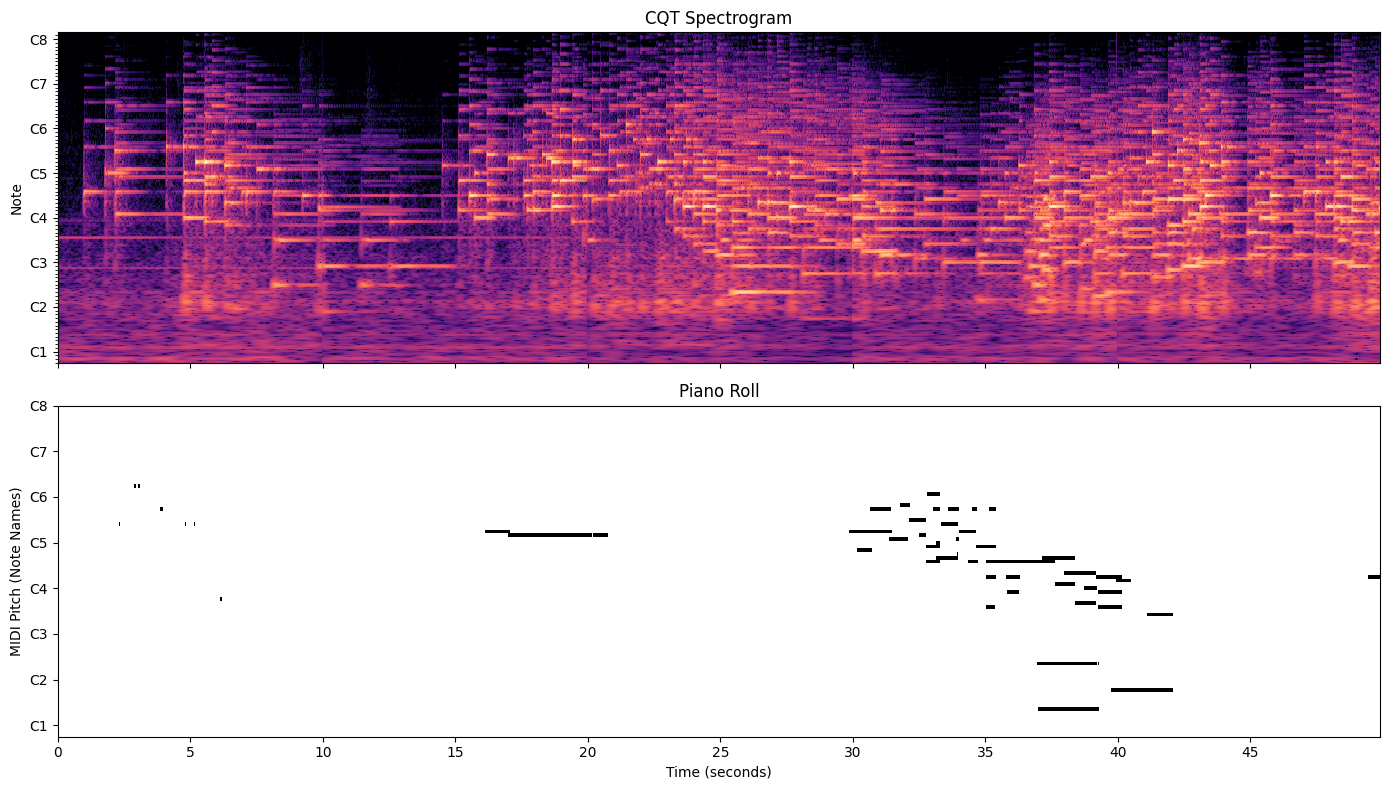

In [43]:
import matplotlib.pyplot as plt
pitch_min = 21    # A0
pitch_max = 108   # C8
duration_sec = X_test.shape[1] * hop_length / sr

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# === Plot CQT ===
librosa.display.specshow(
    X_test,
    sr=sr,
    hop_length=hop_length,
    x_axis='s',                  # <--- force time in seconds
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()  # hide x-label

# === Plot Piano Roll ===
pitch_min = 21
pitch_max = 108

axs[1].imshow(
    piano_roll[pitch_min:pitch_max+1, :],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)

axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label only natural C notes
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()
